CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1051
Rows that have all features = NaN: 21
TRAIN rows: 924
VAL   rows: 106
TEST  rows: 21

=== Training LSTM model ===
[LSTM] Loaded existing model from best_LSTM_Gold_Final.pt
LSTM has no real test data => skip MAPE

=== Training GRU model ===
[GRU] Loaded existing model from best_GRU_Gold_Final.pt
GRU has no real test data => skip MAPE

=== Training RNN model ===
[RNN] Loaded existing model from best_RNN_Gold_Final.pt
RNN has no real test data => skip MAPE

=== Training CNN model ===
[CNN] Loaded existing model from best_CNN_Gold_Final.pt
CNN has no real test data => skip MAPE

=== Training Transformer model ===
[Transformer] Loaded existing model from best_Transformer_Gold_Final.pt


/home/yuzhe/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer has no real test data => skip MAPE

=== Training N-BEATS model ===
[N-BEATS] Loaded existing model from best_N-BEATS_Gold_Final.pt
N-BEATS has no real test data => skip MAPE

=== Training N-HITS model ===
[N-HITS] Loaded existing model from best_N-HITS_Gold_Final.pt
N-HITS has no real test data => skip MAPE


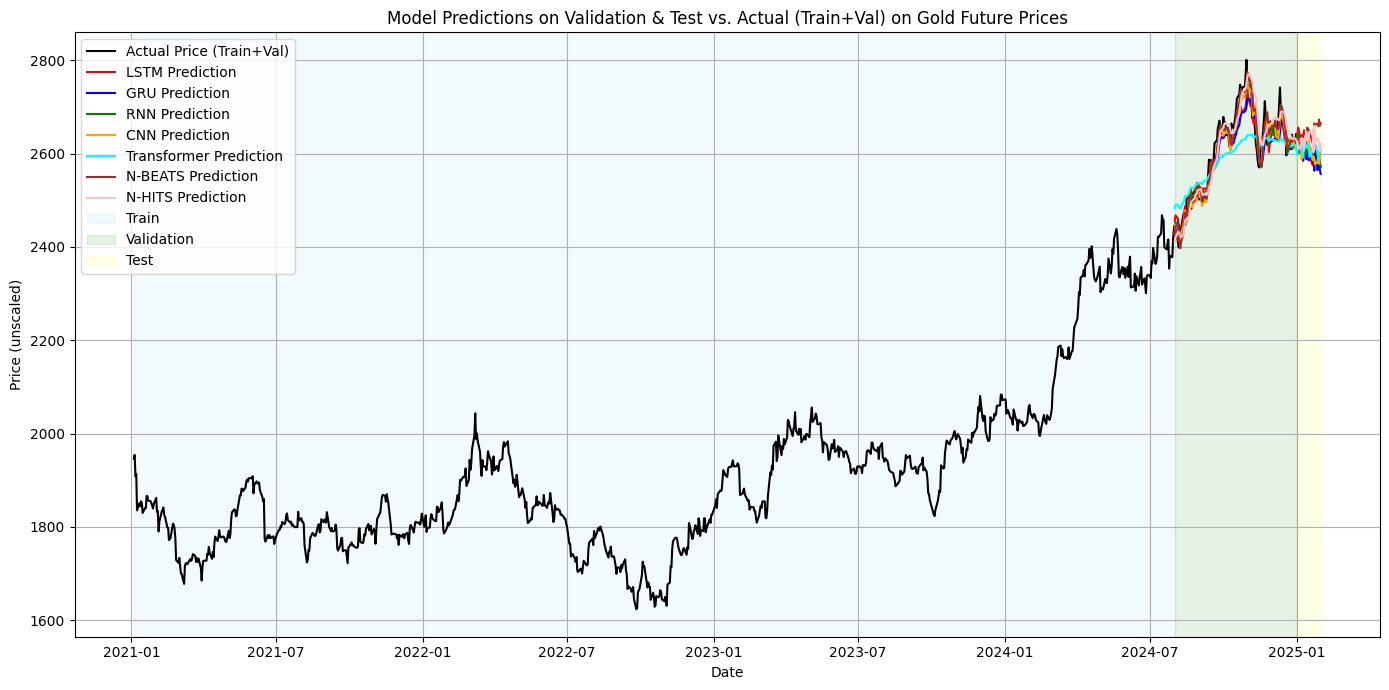

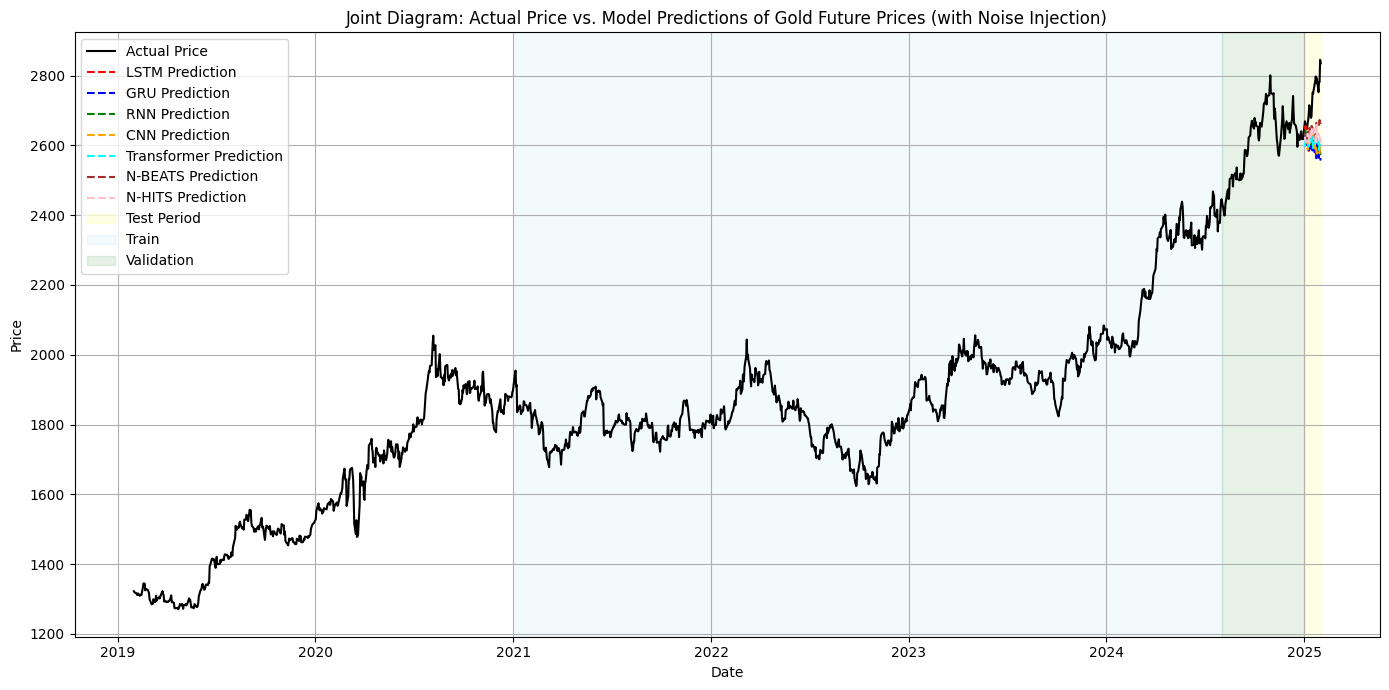

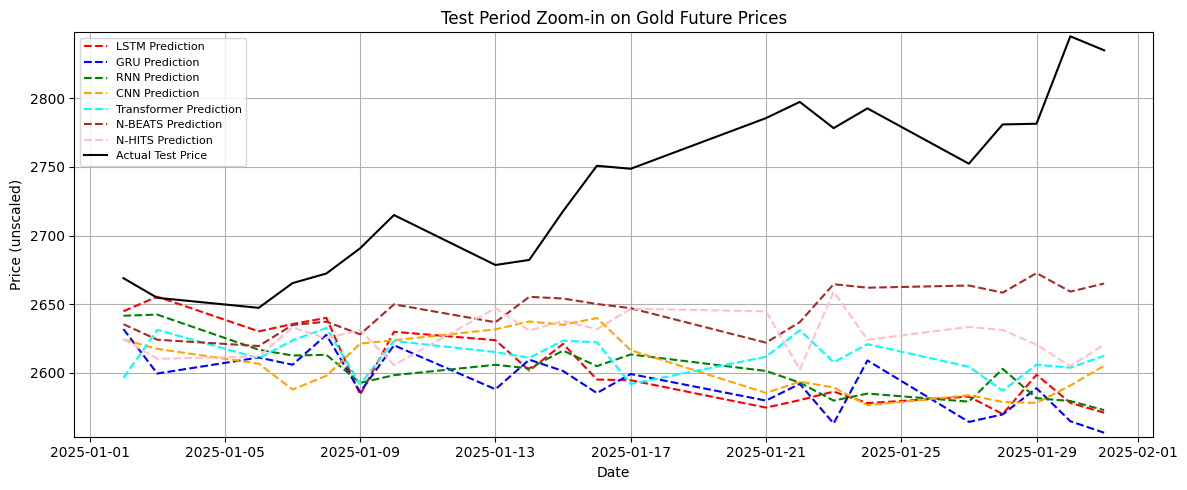

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for the appended models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 30
NUM_EPOCHS  = 2000

features = ["Price", "Open", "High", "Low"]
csv_file = "Gold Futures Historical Data.csv"

###############################################################################
# 2. Load & Clean CSV (Gold Prices Data)
###############################################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# 5A. Create the training sequences
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=8, prefetch_factor=4)

# For sklearn-based models we flatten the time window.
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all remains shape: (n_samples, 4)

###############################################################################
# 5B. "Half-blind" validation loss function (for training)
###############################################################################
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

###############################################################################
# 5C. "Half-blind" validation predictions (non-iterative version)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# NEW: Iterative (next-day) half-blind validation predictions
###############################################################################
def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    Simulates a next-day (iterative) half-blind validation.
    It starts with the final training window (last WINDOW_SIZE rows before val_start),
    then for each validation day:
      - It uses the current window to predict the next day.
      - It then “unveils” the actual observation for that day from df_all_scaled.
      - The window is updated by dropping the oldest row and appending the actual observed row.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    # Initialize current window from the last WINDOW_SIZE rows before validation starts.
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # "Uncover" the actual observation for day d.
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 6. Define the base PyTorch model (supports several types)
###############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        hidden_size = 128
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=2,
                               batch_first=True, dropout=0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=hidden_size, num_layers=2,
                              batch_first=True, dropout=0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=hidden_size, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=3,
                               batch_first=True, dropout=0.3)
            self.bn = nn.BatchNorm1d(hidden_size)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, hidden_size)
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8, dropout=0.2)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(hidden_size, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN", "EnhancedLSTM"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            if self.model_type == "EnhancedLSTM":
                out = self.bn(out)
                out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

###############################################################################
# Early Stopping class
###############################################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

###############################################################################
# 7. Inverse transform helper
###############################################################################
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

###############################################################################
# 8. Training function for PyTorch models
###############################################################################
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    best_path = f"best_{model_type}_Gold_Final.pt"
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            try:
                model.load_state_dict(torch.load(best_path, map_location=device))
                print(f"[{model_type}] Loaded existing model from {best_path}")
            except RuntimeError as e:
                print(f"Error loading checkpoint for {model_type}: {e}. Retraining the model.")
                os.remove(best_path)
    else:
        print(f"No checkpoint found for {model_type}. Training from scratch.")
        
    if not os.path.exists(best_path):
        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(Xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            avg_train_loss = np.mean(train_losses)
            val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
            scheduler.step(val_loss)
            early_stopping(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_path)
            if early_stopping.early_stop:
                print(f"[{model_type}] Early stopping at epoch {epoch+1}")
                break
            if (epoch + 1) % 100 == 0:
                print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
        model.load_state_dict(torch.load(best_path, map_location=device))
    return model

###############################################################################
# 8B. Training function for sklearn-based models (SVM, GPR, Boost)
###############################################################################
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = f"best_{model_type}_Gold_Final.pkl"
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

###############################################################################
# 9. Test-time walk-forward function with optional noise injection
###############################################################################
def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE,
                      add_prediction_noise=False, noise_std=0.01):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            
            if add_prediction_noise:
                noise = np.random.normal(0, noise_std, size=y_pred_4_scaled.shape)
                y_pred_4_scaled += noise

            df_work.loc[idx_current, features] = y_pred_4_scaled
            
            preds.append((d, *y_pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 10. Evaluate & Plot
###############################################################################
def evaluate_and_plot_all_models(results_dict):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    
    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")
    
    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Model Predictions on Validation & Test vs. Actual (Train+Val) on Gold Future Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    



###############################################################################
# 11. MAIN
###############################################################################
if __name__ == "__main__":
    # List of all models to run (both PyTorch and sklearn-based)
    # (We exclude SVM, GPR, and Boost here, but you can add them back if you want.)
    #all_model_types = ["LSTM", "GRU", "RNN", "CNN", "SVM", "Boost", "Transformer", "N-BEATS", "N-HITS"]
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS"]
    
    results_dict = {}
    
    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)
        
        # For some models like Transformer, you might do iterative validation
        if mt in ["Transformer"]:  # or "SVM", "Boost"
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        
        # Do walk-forward test with optional noise injection
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE,
            add_prediction_noise=True,
            noise_std=0.015
        )
        
        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")
    
    evaluate_and_plot_all_models(results_dict)

# ================================
# Additional Plot: Joint Diagram
# ================================
df_actual = pd.read_csv("Gold Futures Historical Data_Complete.csv")
df_actual.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_actual['Date'] = pd.to_datetime(df_actual['Date'])
df_actual.sort_values(by='Date', ascending=True, inplace=True)
df_actual.reset_index(drop=True, inplace=True)

num_cols = df_actual.columns.drop("Date")
df_actual[num_cols] = df_actual[num_cols].replace({',': ''}, regex=True)
df_actual[num_cols] = df_actual[num_cols].astype('float64')

actual_dates = df_actual['Date']
actual_prices = df_actual['Price']

for model_name, pred_info in results_dict.items():
    if pred_info["test_pred_df"] is not None and not pred_info["test_pred_df"].empty:
        pred_info["test_pred_df"]['Date'] = pd.to_datetime(pred_info["test_pred_df"]['Date'])

plt.figure(figsize=(14, 7))
plt.plot(actual_dates, actual_prices, color='black', linewidth=1.5, label='Actual Price')

model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple"
}

for model_name, pred_info in results_dict.items():
    test_df = pred_info["test_pred_df"]
    if test_df is not None and not test_df.empty:
        plt.plot(pd.to_datetime(test_df["Date"]), test_df["Pred_Price_unscaled"],
                 color=model_colors.get(model_name, "gray"),
                 linestyle="--", linewidth=1.5,
                 label=f'{model_name} Prediction')

test_period_start = pd.to_datetime("2025-01-02")
plt.axvspan(test_period_start, actual_dates.iloc[-1], color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label='Train')
plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label='Validation')

plt.title("Joint Diagram: Actual Price vs. Model Predictions of Gold Future Prices (with Noise Injection)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# ================================
# Additional Cell: Test Period Zoom-in with Actual from "Gold Futures Historical Data_Complete.csv"
# ================================
# 1) Filter out only the test subset from your merged predictions
#    or reconstruct the test subset from your 'results_dict' if needed.
def plot_test_period_zoom(results_dict, df_scaled, test_cutoff):
    # Create a combined DataFrame of predictions from each model during the test period
    # along with the 'Date' column for alignment.
    test_dfs = []
    for model_name, pred_info in results_dict.items():
        if pred_info["test_pred_df"] is not None:
            df_model_test = pred_info["test_pred_df"].copy()
            df_model_test["Date"] = pd.to_datetime(df_model_test["Date"])
            df_model_test.sort_values("Date", inplace=True)
            df_model_test.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}, inplace=True)
            test_dfs.append(df_model_test[["Date", f"Pred_{model_name}"]])
    if not test_dfs:
        print("No test predictions found.")
        return
    
    # Merge all test predictions on the 'Date' column
    from functools import reduce
    merged_test_df = reduce(
        lambda left, right: pd.merge(left, right, on="Date", how="outer"),
        test_dfs
    )
    merged_test_df.sort_values("Date", inplace=True)
    
    # 2) Load the complete CSV with actual unscaled test prices
    try:
        df_complete = pd.read_csv("Gold Futures Historical Data_Complete.csv")
    except FileNotFoundError:
        print("Could not find 'Gold Futures Historical Data_Complete.csv' for actual test overlay.")
        return
    
    df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"])
    df_complete.sort_values("Date", inplace=True)
    
    # Convert the Price column to float
    df_complete["Price"] = (
        df_complete["Price"]
        .astype(str)
        .str.replace(",", "", regex=True)
        .astype(float)
    )
    
    # 3) Filter the actual test period
    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
    
    # 4) Plot each model's prediction
    plt.figure(figsize=(12, 5))
    
    model_colors = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "Boost": "purple"
    }
    
    for model_name, pred_info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_test_df.columns:
            plt.plot(
                merged_test_df["Date"], merged_test_df[col],
                color=model_colors.get(model_name, "gray"),
                linestyle="--",
                label=f"{model_name} Prediction"
            )
    
    # 5) Plot the actual test prices
    plt.plot(df_test_actual["Date"], df_test_actual["Price"],
             color='black', linewidth=1.5, label='Actual Test Price')
    
    # 6) Automatically adjust the y-limits so we see all lines clearly
    all_preds = []
    for model_name, pred_info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_test_df.columns:
            numeric_preds = pd.to_numeric(merged_test_df[col], errors="coerce").dropna()
            all_preds.extend(numeric_preds.tolist())
    
    # Incorporate the actual test prices
    all_preds.extend(df_test_actual["Price"].dropna().values.tolist())
    
    if all_preds:
        min_val, max_val = np.min(all_preds), np.max(all_preds)
        padding = 0.01 * (max_val - min_val)
        plt.ylim(min_val - padding, max_val + padding)
    
    plt.title("Test Period Zoom-in on Gold Future Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend(prop={'size':8})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with your existing variables:
plot_test_period_zoom(results_dict, df_scaled, test_cutoff)
